In [1]:
import cyrtranslit as ct
import datasets as ds
import pandas as pd

In [2]:
flores = ds.load_from_disk("../data-bin/flores-dev-no-orth/")
ntrex = ds.load_from_disk("../data-bin/ntrex-no-orth/")

Let's make sure Serbian is in Cyrillic too. When I remove the orthography, the latest version of Serbian gets saved, i.e. the Latin version.

In [3]:
ntrex['srp'][0]

{'text': 'Velški članovi skupštine su zabrinuti zbog „sličnosti sa Mapetovcima“',
 'language': 'srp'}

In [4]:
srp_cyrl = ds.load_from_disk("../data-bin/ntrex/srp-Cyrl/")

In [5]:
def fix_lang(ex):
    ex['language'] = [l.replace("-Cyrl", "") for l in ex['language']]
    return ex

In [6]:
srp_cyrl = srp_cyrl.map(fix_lang, batched=True)

Loading cached processed dataset at /home/jonne/research/ling-rel-transfer/ling-inf-transfer/data-bin/ntrex/srp-Cyrl/cache-fef3e13bbda83700.arrow


In [7]:
ntrex['srp'] = srp_cyrl

In [8]:
ntrex['srp'][0]

{'text': 'Велшки чланови скупштине су забринути због „сличности са Мапетовцима“',
 'language': 'srp'}

Languages supported by `cyrtransliterate`: Bulgarian, Montenegrin, Macedonian, Mongolian, Russian, Serbian, Tajik, and Ukrainian.

In [9]:
language_codes = {
    "Bulgarian": {
        "flores": 'bul',
        "ntrex": 'bul'
    },
    "Macedonian": {
        "flores": 'mkd',
        "ntrex": "mkd"
    },
    "Mongolian": {
        "flores": "khk",
        "ntrex": "mon"
    },
    "Russian": {
        "flores": "rus",
        "ntrex": "rus"
    },
    "Serbian": {
        "flores": "srp",
        "ntrex": "srp"
    },
    "Tajik": {
        "flores": "tgk",
        "ntrex": "tgk"
    },
    "Ukrainian": {
        "flores": "ukr",
        "ntrex": "ukr"
    }
}

In [10]:
supported_languages = list(language_codes)

In [11]:
supported_languages

['Bulgarian',
 'Macedonian',
 'Mongolian',
 'Russian',
 'Serbian',
 'Tajik',
 'Ukrainian']

In [12]:
train_data_cyr = ds.concatenate_datasets([ntrex[language_codes[lang]["ntrex"]] for lang in supported_languages])
test_data_cyr = ds.concatenate_datasets([flores[language_codes[lang]["flores"]] for lang in supported_languages])

In [13]:
def fix_mongolian(ex):
    out = []
    for lang in ex['language']:
        if lang == 'mon':
            out.append('khk')
        else:
            out.append(lang)
    ex['language'] = out
    return ex

In [14]:
train_data_cyr = train_data_cyr.map(fix_mongolian, batched=True, batch_size=10000)

Loading cached processed dataset at /home/jonne/research/ling-rel-transfer/ling-inf-transfer/data-bin/ntrex-no-orth/bul/cache-0acd1e1ef289453f.arrow


In [15]:
language_codes

{'Bulgarian': {'flores': 'bul', 'ntrex': 'bul'},
 'Macedonian': {'flores': 'mkd', 'ntrex': 'mkd'},
 'Mongolian': {'flores': 'khk', 'ntrex': 'mon'},
 'Russian': {'flores': 'rus', 'ntrex': 'rus'},
 'Serbian': {'flores': 'srp', 'ntrex': 'srp'},
 'Tajik': {'flores': 'tgk', 'ntrex': 'tgk'},
 'Ukrainian': {'flores': 'ukr', 'ntrex': 'ukr'}}

In [16]:
reverse_language_codes_map = {}
for language, code_dict in language_codes.items():
    flores_code = code_dict['flores']
    ntrex_code = code_dict['ntrex']
    reverse_language_codes_map[flores_code] = language
    reverse_language_codes_map[ntrex_code] = language

In [17]:
reverse_language_codes_map

{'bul': 'Bulgarian',
 'mkd': 'Macedonian',
 'khk': 'Mongolian',
 'mon': 'Mongolian',
 'rus': 'Russian',
 'srp': 'Serbian',
 'tgk': 'Tajik',
 'ukr': 'Ukrainian'}

In [18]:
cyrtranslate_language_map = dict(
    zip(
        ['Bulgarian', 'Montenergrin', 'Macedonian', 'Mongolian', 'Russian', 'Serbian', 'Tajik', 'Ukrainian'],
        ['bg', 'me', 'mk', 'mn', 'ru', 'sr', 'tj', 'ua']
    )
)

In [19]:
cyrtranslate_language_map

{'Bulgarian': 'bg',
 'Montenergrin': 'me',
 'Macedonian': 'mk',
 'Mongolian': 'mn',
 'Russian': 'ru',
 'Serbian': 'sr',
 'Tajik': 'tj',
 'Ukrainian': 'ua'}

In [20]:
def romanize(ex, add_suffix=True):
    languages = ex['language']
    texts = ex['text']
    romanized = []
    for lang, text in zip(languages, texts):
        language_long = reverse_language_codes_map[lang]
        ct_code = cyrtranslate_language_map[language_long]
        latn = ct.to_latin(text, lang_code=ct_code)
        romanized.append(latn)
        
    ex['text'] = romanized
    if add_suffix:
        ex['language'] = [f"{lang}-rom" for lang in languages]
    
    return ex

In [21]:
import functools as ft

In [22]:
_romanize = ft.partial(romanize, add_suffix=False)

In [23]:
train_data_rom = train_data_cyr.map(_romanize, batched=True, batch_size=10000)

Loading cached processed dataset at /home/jonne/research/ling-rel-transfer/ling-inf-transfer/data-bin/ntrex-no-orth/bul/cache-1a245e89b76499f4.arrow


In [24]:
test_data_rom = test_data_cyr.map(_romanize, batched=True, batch_size=10000)

Loading cached processed dataset at /home/jonne/research/ling-rel-transfer/ling-inf-transfer/data-bin/flores-dev-no-orth/bul/cache-365341cd29e78ca9.arrow


In [25]:
train_data = ds.concatenate_datasets([train_data_cyr, train_data_rom])

In [26]:
test_data = ds.concatenate_datasets([test_data_cyr, test_data_rom])

### Sklearn baseline

In [27]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.feature_extraction import DictVectorizer

In [28]:
bow_vec = CountVectorizer(ngram_range=(2,2))
char_vec = CountVectorizer(analyzer='char', ngram_range=(2,2))

In [29]:
sentences_train = train_data['text']
sentences_test = test_data['text']

In [30]:
X_train_word = bow_vec.fit_transform(sentences_train)
X_train_char = char_vec.fit_transform(sentences_train)

In [31]:
X_test_word = bow_vec.transform(sentences_test)
X_test_char = char_vec.transform(sentences_test)

In [32]:
y_train = train_data['language']
y_test = test_data['language']

#### Bag of words

In [33]:
from sklearn.linear_model import LogisticRegression

In [34]:
bow_model = LogisticRegression(max_iter=1000)

In [35]:
bow_model = bow_model.fit(X_train_word, y_train)

In [36]:
y_pred = bow_model.predict(X_test_word)
y_pred_proba = bow_model.predict_proba(X_test_word)

In [37]:
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt

In [38]:
ordered_languages = pd.value_counts(test_data['language']).index.tolist()

Text(0.5, 1.0, 'Features: Word bigrams\nModel: Logistic regression')

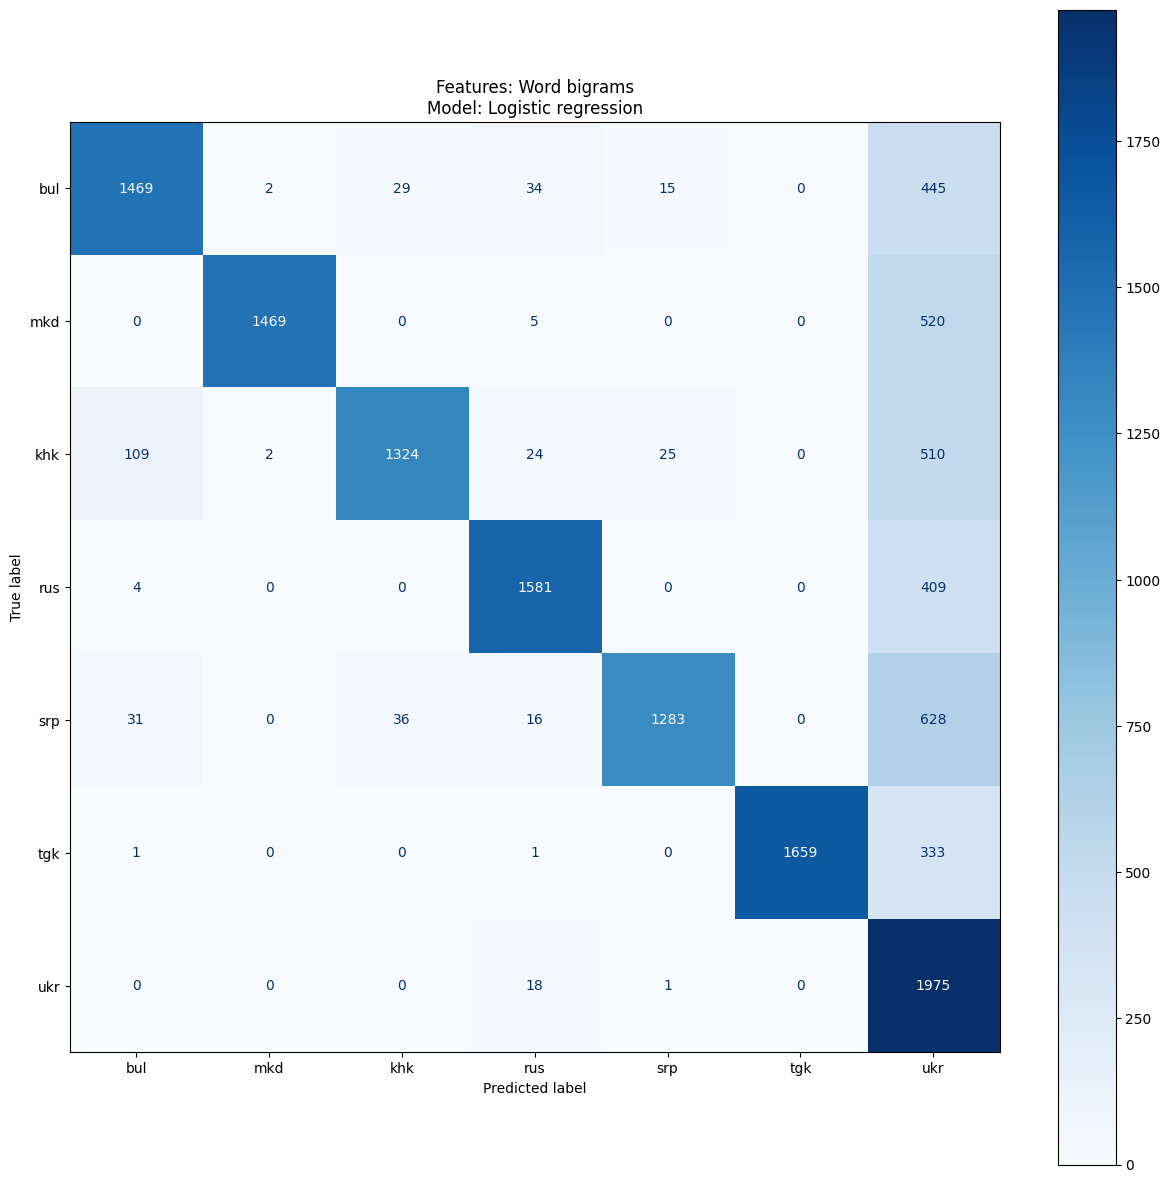

In [39]:
fig, ax = plt.subplots(figsize=(15, 15))
ConfusionMatrixDisplay.from_estimator(
        bow_model,
        X_test_word,
        y_test,
        display_labels=ordered_languages,
        cmap=plt.cm.Blues,
        normalize=None,
#         values_format='.2f',
    ax=ax
)
plt.title("Features: Word bigrams\nModel: Logistic regression")

## Bag of chars

In [40]:
boc_model = LogisticRegression(max_iter=1000)
boc_model = boc_model.fit(X_train_char, y_train)
y_pred_char = boc_model.predict(X_test_char)
y_pred_proba_char = boc_model.predict_proba(X_test_char)

Text(0.5, 1.0, 'Features: Char bigrams\nModel: Logistic regression')

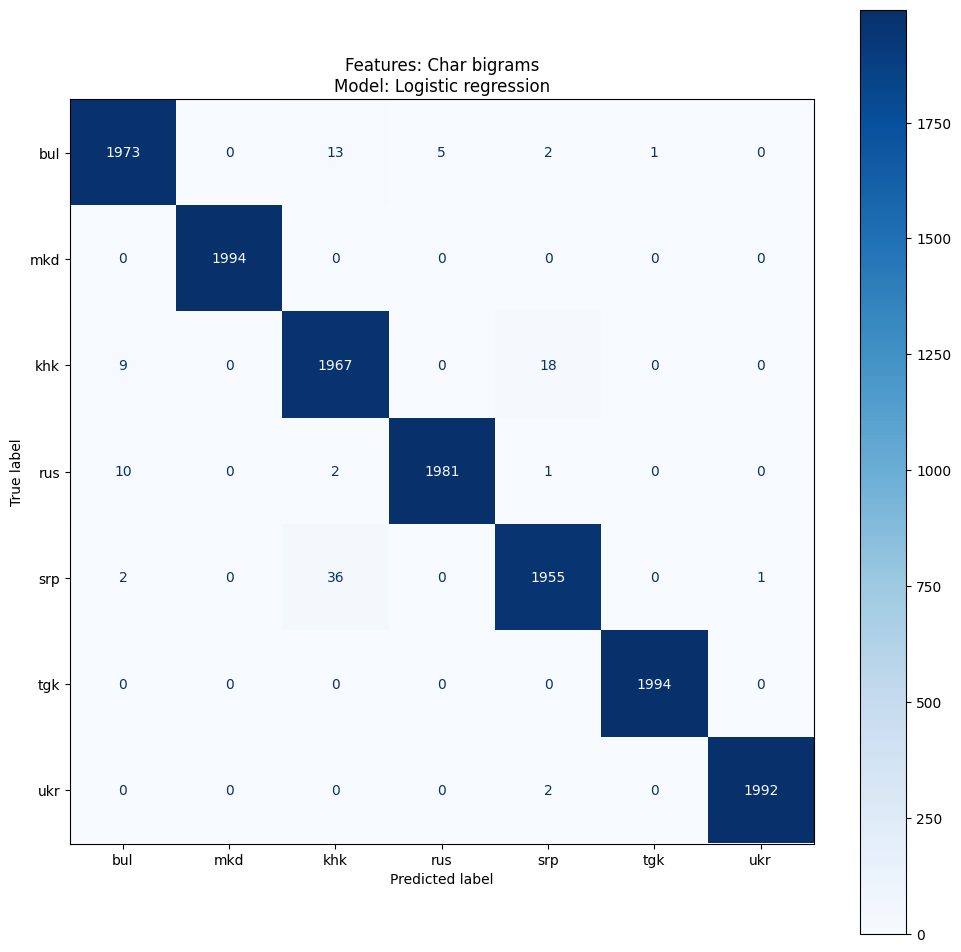

In [41]:
fig, ax = plt.subplots(figsize=(12, 12))
ConfusionMatrixDisplay.from_estimator(
        boc_model,
        X_test_char,
        y_test,
        display_labels=ordered_languages,
        cmap=plt.cm.Blues,
        normalize=None,
        values_format='',
        ax=ax,
)
plt.title('Features: Char bigrams\nModel: Logistic regression')

In [42]:
char_preds_df = pd.DataFrame()
char_preds_df['sentence'] = test_data['text']
char_preds_df['language'] = y_test
char_preds_df['language_pred'] = y_pred_char

In [43]:
char_preds_df['correct'] = char_preds_df.language == char_preds_df.language_pred

In [49]:
word_preds_df = pd.DataFrame()
word_preds_df['sentence'] = test_data['text']
word_preds_df['language'] = y_test
word_preds_df['language_pred'] = y_pred

In [50]:
word_preds_df['correct'] = word_preds_df.language == word_preds_df.language_pred

In [52]:
word_misclassification_counts = word_preds_df[(~word_preds_df.correct)].groupby("language").language_pred.value_counts()

In [53]:
def identify_language_bow_model(sentence):
    return bow_model.predict(bow_vec.transform([sentence]))[0]

In [54]:
def identify_language_boc_model(sentence):
    return boc_model.predict(char_vec.transform([sentence]))[0]

## Feature extraction pipeline

In [78]:
import transformers as tf
import numpy as np

In [94]:
feat_ext = tf.pipeline("feature-extraction", model='bert-base-multilingual-cased', return_tensors="pt", pad=True)

Some weights of the model checkpoint at bert-base-multilingual-cased were not used when initializing BertModel: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [80]:
def to_numpy(t):
    return t.cpu().detach().numpy()

In [91]:
import torch

In [101]:
torch.cat?

In [111]:
from tqdm import tqdm

In [115]:
def extract_features(sentences):
    feats = feat_ext(sentences)
    return torch.stack([
        feat[0][0]
    for feat in tqdm(feats)])

In [ ]:
X_train_mbert = extract_features(sentences_train)
X_test_mbert = extract_features(sentences_test)

In [ ]:
mbert_model = LogisticRegression(max_iter=1000)

In [ ]:
mbert_model = mbert_model.fit(X_train_mbert, y_train)

```python
    # Load the XLM-R tokenizer and model
    tokenizer = AutoTokenizer.from_pretrained(model_name)

    model = AutoModelForSequenceClassification.from_pretrained(
        model_name, num_labels=max(language_to_id.values())
    )

    pprint("Classifier:")
    pprint(model.classifier)

    def preprocess_function(examples):
        inputs = examples["text"]
        labels = [language_to_id[label] for label in examples["label"]]

        model_inputs = tokenizer(
            inputs, padding=True, truncation=True, max_length=max_length_tokens
        )
        model_inputs["label"] = labels

        return model_inputs

    data_for_finetune = data_for_finetune.map(preprocess_function, batched=True)
    data_for_test = data_for_test.map(preprocess_function, batched=True)

    # Define the training arguments

    if max_steps:
        how_long_to_train_args = {
            "max_steps": max_steps,
        }
    else:
        how_long_to_train_args = {
            "num_train_epochs": num_train_epochs,
        }

    training_args = TrainingArguments(
        output_dir=output_dir,
        per_device_train_batch_size=batch_size,
        per_device_eval_batch_size=batch_size,
        save_total_limit=save_total_limit,
        learning_rate=learning_rate,
        save_steps=save_steps,
        eval_steps=eval_steps,
        evaluation_strategy="no"

        if eval_steps < 0
        else {0: "epoch"}.get(eval_steps, "steps"),
        warmup_steps=warmup_steps,
        logging_steps=logging_steps,
        logging_strategy="no"

        if logging_steps < 0
        else {0: "epoch"}.get(logging_steps, "steps"),
        overwrite_output_dir=True,
        **how_long_to_train_args,
    )

    pprint("Training args:")
    pprint(training_args)

    data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
    _langs_set = set(finetune_langs) | set(test_langs)

    def compute_metrics(eval_pred):
        predictions, labels = eval_pred
        predictions = np.argmax(predictions, axis=1)

        metrics = {
            "macro_f1": f1.compute(
                predictions=predictions, references=labels, average="macro"
            )["f1"],
            "micro_f1": f1.compute(
                predictions=predictions, references=labels, average="micro"
            )["f1"],
        }

        # Per-class F1s
        class_f1s = f1.compute(
            predictions=predictions, references=labels, average=None
        )["f1"]
        class_ids = sorted(set(predictions) | set(labels))
        f1s_per_class = {
            id_to_language[class_id]: f1_score

            for class_id, f1_score in zip(class_ids, class_f1s)
        }

        # Score each test lang

        for lang in test_langs:
            metrics[f"f1_{lang}"] = f1s_per_class.get(lang, 0)

        # Confusion matrix
        labels_human_readable = [id_to_language[i] for i in labels]
        predictions_human_readable = [id_to_language[i] for i in predictions]

        for hum_readable in labels_human_readable, predictions_human_readable:
            _langs_set.update(hum_readable)

        _langs = sorted(_langs_set)

        remove_zero_rows = lambda df: df.loc[~(df == 0).all(axis=1)]
        remove_zero_cols = lambda df: df.loc[:, (df != 0).any(axis=0)]

        cm = confusion_matrix(
            y_true=labels_human_readable,
            y_pred=predictions_human_readable,
            labels=_langs,
        )
        confusion_df = pd.DataFrame(cm)
        confusion_df.columns = _langs
        confusion_df.index = _langs
        confusion_df = remove_zero_rows(confusion_df)
        confusion_df = remove_zero_cols(confusion_df)

        print("\n\n")
        pprint(confusion_df)
        print("\n\n")

        return metrics

    # Grab _N random rows from finetuning and test datasets

    if debug:
        _N = 100
        finetune_random_indices = np.random.choice(
            len(data_for_finetune), _N, replace=False
        )
        test_random_indices = np.random.choice(len(data_for_test), _N, replace=False)
        data_for_finetune = data_for_finetune.select(finetune_random_indices)
        data_for_test = data_for_test.select(test_random_indices)

    # Define the trainer
    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=data_for_finetune,
        eval_dataset=data_for_test,
        data_collator=data_collator,
        tokenizer=tokenizer,
        compute_metrics=compute_metrics,
    )

    # Evaluate the model before finetuning
    pprint("Pre-finetune eval")
    metrics_pre_finetune = trainer.evaluate()
    pprint(metrics_pre_finetune)

    # Finetune the model
    trainer.train()

    # Evaluate the model after finetuning
    pprint("Post-finetune eval")
    metrics_post_finetune = trainer.evaluate()
    pprint(metrics_post_finetune)

    
```   